In [1]:
import sys
sys.path.append('../')
from read_json import load_from_json
from parse_cedar_objects import parse_cedar_params
import nengo
import numpy as np
import matplotlib.pyplot as plt

In [2]:
objects, connections = load_from_json('../JSON/test_architecture.json')

In [3]:
model = nengo.Network()

with model:
    nengo_objects = {}
    for ob_key in objects:
        print(ob_key)
        name, instance = parse_cedar_params(objects[ob_key])
        instance.make_node()
        nengo_objects[name] = instance

Flip
Gauss Input 2
Projection
Projection 2
Spatial Template
Group 1.Component Multiply
Group 1.Neural Field
Group 1.Static Gain
Group 2.Gauss Input
Group 2.Neural Field 2


In [4]:
nengo_objects

{'Flip': <cedar_modules.Flip at 0x7f9e5debd8d0>,
 'Gauss Input 2': <cedar_modules.GaussInput at 0x7f9e5debd978>,
 'Projection': <cedar_modules.Projection at 0x7f9e5debd7f0>,
 'Projection 2': <cedar_modules.Projection at 0x7f9e5debda20>,
 'Spatial Template': <cedar_modules.SpatialTemplate at 0x7f9e5debda90>,
 'Group 1.Component Multiply': <cedar_modules.ComponentMultiply at 0x7f9e5debda58>,
 'Group 1.Neural Field': <cedar_modules.NeuralField at 0x7f9e5debdb70>,
 'Group 1.Static Gain': <cedar_modules.StaticGain at 0x7f9e5debdbe0>,
 'Group 2.Gauss Input': <cedar_modules.GaussInput at 0x7f9e5debdc88>,
 'Group 2.Neural Field 2': <cedar_modules.NeuralField at 0x7f9e5dbea1d0>}

In [5]:
def make_connection(source_name, target_name, object_dict):
    source = source_name.rsplit('.',1)[0]
    target = target_name.rsplit('.',1)[0]
    
    # there are two special cases where the type of object
    # changes the connection that is made 
    # 1. special case: the target is a ComponentMultiply
    if object_dict[target].__class__.__name__ == 'ComponentMultiply':
        target_obj = object_dict[target]
        if object_dict[target].connections == 0:
            # connect to the first entries
            nengo.Connection(object_dict[source].node, 
                             target_obj.node[:np.product(target_obj.inp_size1)],
                             synapse=0)
            object_dict[target].connections += 1
        elif object_dict[target].connections == 1:
            # connect to the last entries
            nengo.Connection(object_dict[source].node, 
                             target_obj.node[np.product(target_obj.inp_size1):],
                             synapse=0)
            # count plus 1 again to realize when trying to add a third connection
            object_dict[target].connections += 1
        else:
            print('Too many connections for ComponentMultiply!')
    # 2. special case: the target is a Convolution
    elif object_dict[target].__class__.__name__ == 'Convolution':
        # the source can be the kernel or the matrix
        target_obj = object_dict[target]
        if target_name.rsplit('.',1)[1] == 'kernel':
            nengo.Connection(object_dict[source].node, 
                             target_obj.node[:np.prod(target_obj.sizes)],
                             synapse=0)
        # if it's not the kernel, it's the matrix
        else:
            nengo.Connection(object_dict[source].node, 
                             target_obj.node[:np.prod(target_obj.sizes)],
                             synapse=0)
    # just normal connection
    else:
        nengo.Connection(object_dict[source].node, object_dict[target].node,
                         synapse=0)
            
    

In [6]:
with model:
    for connection in connections:
        print(connection[0][1], connection[1][1])
        make_connection(connection[0][1], connection[1][1], nengo_objects)
    
    probes = {}
    for key in nengo_objects:
        probes[key] = nengo.Probe(nengo_objects[key].node)

Group 1.Static Gain.output Flip.input
Group 2.Neural Field 2.sigmoided activation Projection.input
Group 2.Neural Field 2.sigmoided activation Projection 2.input
Gauss Input 2.Gauss input Group 1.Component Multiply.operands
Spatial Template.spatial pattern Group 1.Component Multiply.operands
Spatial Template.spatial pattern Group 1.Static Gain.input
Group 1.Neural Field.sigmoided activation Group 2.Neural Field 2.input
Group 1.Component Multiply.product Group 1.Neural Field.input
Group 1.Static Gain.output Group 1.Neural Field.input
Group 2.Gauss Input.Gauss input Group 2.Neural Field 2.input


In [7]:
sim = nengo.Simulator(model)
with sim:
    sim.run(0.1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

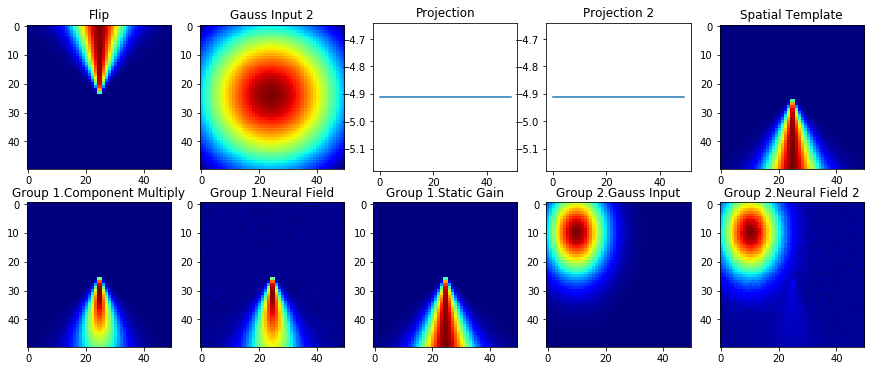

In [8]:
plt.figure(figsize=(15,6))
for i, key in enumerate(probes):
    plt.subplot(2,5, i+1)
    probe_data = sim.data[probes[key]]
    if probe_data.shape[1] == 2500:
        plt.title(key)
        plt.imshow(probe_data[10,:].reshape(50,50), cmap='jet')
    else:
        plt.title(key)
        plt.plot(probe_data[10,:])
        
plt.show()
        